In [1]:
# 1. Importar librerías
import pandas as pd
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Función para convertir coordenadas DMS a decimales

def dms_to_decimal(coord):
    match = re.match(r"(\d+)°(\d+)'([\d\.]+)\" ([NSEW])", str(coord))
    if not match:
        return None

    grados = int(match.group(1))
    minutos = int(match.group(2))
    segundos = float(match.group(3))
    direccion = match.group(4)

    decimal = grados + minutos/60 + segundos/3600

    if direccion in ["S", "W"]:
        decimal = -decimal

    return decimal

In [3]:
# 3. Leer base de GRAPROES (INEGI)

censo = pd.read_excel("/content/graproes.xlsx")

# Convertir columnas de coordenadas
censo["LAT_DECIMAL"] = censo["LATITUD"].apply(dms_to_decimal)
censo["LON_DECIMAL"] = censo["LONGITUD"].apply(dms_to_decimal)

# Filtrar columnas necesarias
censo = censo[["NOM_LOC", "LAT_DECIMAL", "LON_DECIMAL", "GRAPROES"]].dropna()

print("Vista previa de la base del censo:")
censo.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/graproes.xlsx'

In [ ]:
# 4. Leer base de datos de robos (FICOSEC)

df = pd.read_excel("/content/IPH_robos_ene-ago-2025_tecmty.xlsx")

# Asegurar que las columnas sean numéricas
df["LATITUD"] = pd.to_numeric(df["LATITUD"], errors="coerce")
df["LONGITUD"] = pd.to_numeric(df["LONGITUD"], errors="coerce")
df = df.dropna(subset=["LATITUD", "LONGITUD"])

# Renombrar columnas a formato decimal
df = df.rename(columns={"LATITUD": "LAT_DECIMAL", "LONGITUD": "LON_DECIMAL"})

print("Vista previa de la base de robos:")
df.head()

Vista previa de la base de robos:


,FOLIO,FECHA,HORA,MINUTO,TIPO,VOLENCIA,LAT_DECIMAL,LON_DECIMAL,DISTRITO,CUADRANTE
0,759476,2025-01-01,5,11,ROBO A NEGOCIO,SI,28.600113,-106.061258,Zapata,76
1,759978,2025-01-01,5,25,ROBO A NEGOCIO,SI,28.609652,-106.065990,Zapata,75
2,760050,2025-01-01,6,31,ROBO DE VEHICULO,NO,28.639322,-106.039862,Morelos,51
3,760404,2025-01-01,11,50,ROBO A CASA HABITACION,NO,28.643275,-106.030795,Morelos,51
4,769412,2025-01-01,12,0,ROBO A NEGOCIO,NO,28.693501,-106.115590,Villa,17


In [ ]:
# 5. Cruzar con k-NN (vincular GRAPROES a cada robo)

nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(censo[["LAT_DECIMAL", "LON_DECIMAL"]])
distancias, indices = nn.kneighbors(df[["LAT_DECIMAL", "LON_DECIMAL"]])

# Asignar GRAPROES y localidad a cada registro de robo
df["GRAPROES"] = censo.iloc[indices.flatten()]["GRAPROES"].values
df["NOM_LOC"] = censo.iloc[indices.flatten()]["NOM_LOC"].values

print("Vista previa de la base enriquecida:")
df.head(10)

Vista previa de la base enriquecida:


,FOLIO,FECHA,HORA,MINUTO,TIPO,VOLENCIA,LAT_DECIMAL,LON_DECIMAL,DISTRITO,CUADRANTE,GRAPROES,NOM_LOC
0,759476,2025-01-01,5,11,ROBO A NEGOCIO,SI,28.600113,-106.061258,Zapata,76,8.13,Las Casas
1,759978,2025-01-01,5,25,ROBO A NEGOCIO,SI,28.609652,-106.065990,Zapata,75,8.13,Las Casas
2,760050,2025-01-01,6,31,ROBO DE VEHICULO,NO,28.639322,-106.039862,Morelos,51,9.15,Los Pericos
3,760404,2025-01-01,11,50,ROBO A CASA HABITACION,NO,28.643275,-106.030795,Morelos,51,9.15,Los Pericos
4,769412,2025-01-01,12,0,ROBO A NEGOCIO,NO,28.693501,-106.115590,Villa,17,12.13,Bloquera Muruato
5,760412,2025-01-01,12,6,ROBO A NEGOCIO,NO,28.693475,-106.115476,Villa,17,12.13,Bloquera Muruato
6,760559,2025-01-01,13,47,ROBO DE VEHICULO,NO,28.771511,-106.161973,Colón,3,8.19,Colonia Agrícola Francisco Villa
7,761131,2025-01-01,19,10,ROBO A CASA HABITACION,NO,28.662759,-105.948717,Morelos,48,8.57,Santa Lucía
8,762249,2025-01-02,9,10,ROBO DE VEHICULO,NO,28.587403,-106.040247,Morelos,59,7.40,Colonia la Paz
9,762311,2025-01-02,9,42,ROBO A NEGOCIO,NO,28.631906,-106.121163,Diana,32,6.57,Los Fernández


In [ ]:
# =====================================
# 6. Procesar variable de hora
# =====================================
df["HORA"] = pd.to_datetime(df["HORA"], errors="coerce").dt.hour
df["HORA"] = df["HORA"].fillna(0).astype(int)

In [ ]:
# =====================================
# 7. Preparar datos para el clúster de contexto
# =====================================
df = df.dropna(subset=["TIPO", "GRAPROES"])

# Codificar el tipo de robo (de texto a número)
le = LabelEncoder()
df["TIPO_COD"] = le.fit_transform(df["TIPO"])

# Escalar las variables para evitar sesgos
scaler = StandardScaler()
X = scaler.fit_transform(df[["TIPO_COD", "HORA", "GRAPROES"]])

In [ ]:
# =====================================
# 8. Aplicar KMeans (agrupación no supervisada)
# =====================================
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster_Contexto"] = kmeans.fit_predict(X)

print("Distribución de registros por clúster:\n", df["Cluster_Contexto"].value_counts(), "\n")

Distribución de registros por clúster:
 Cluster_Contexto
3    450
2    259
1    238
0    152
Name: count, dtype: int64 



In [ ]:
# =====================================
# 9. Crear mapa de calor en Folium
# =====================================
centro_chihuahua = [28.6353, -106.0889]
m = folium.Map(location=centro_chihuahua, zoom_start=12, tiles="CartoDB positron")

heat_data = df[["LAT_DECIMAL", "LON_DECIMAL", "GRAPROES"]].dropna().values.tolist()

HeatMap(
    heat_data,
    radius=10,
    blur=15,
    min_opacity=0.3,
    max_opacity=0.9
).add_to(m)

# Colores por clúster
colores = ['red', 'blue', 'green', 'purple']

for _, row in df.sample(min(300, len(df)), random_state=42).iterrows():
    folium.CircleMarker(
        location=[row["LAT_DECIMAL"], row["LON_DECIMAL"]],
        radius=3,
        color=colores[row["Cluster_Contexto"]],
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"<b>Tipo:</b> {row['TIPO']}<br>"
            f"<b>Hora:</b> {row['HORA']}<br>"
            f"<b>GRAPROES:</b> {row['GRAPROES']:.2f}<br>"
            f"<b>Cluster contexto:</b> {row['Cluster_Contexto']}<br>"
            f"<b>Localidad:</b> {row['NOM_LOC']}"
        )
    ).add_to(m)

legend_html = """
<div style="
    position: fixed;
    bottom: 30px; left: 30px; width: 250px; height: 180px;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white; padding:10px;
">
<b>📊 Clúster de Contexto del Robo</b><br>
<span style="color:red;">●</span> Cluster 0 – Robos nocturnos, zonas con GRAPROES bajo<br>
<span style="color:blue;">●</span> Cluster 1 – Robos diurnos, zonas con GRAPROES medio<br>
<span style="color:green;">●</span> Cluster 2 – Robos mixtos, GRAPROES alto<br>
<span style="color:purple;">●</span> Cluster 3 – Diversos tipos / zonas mixtas<br>
<hr>
🔥 Mapa de calor = Densidad de robos ponderada por nivel educativo
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

In [ ]:
m

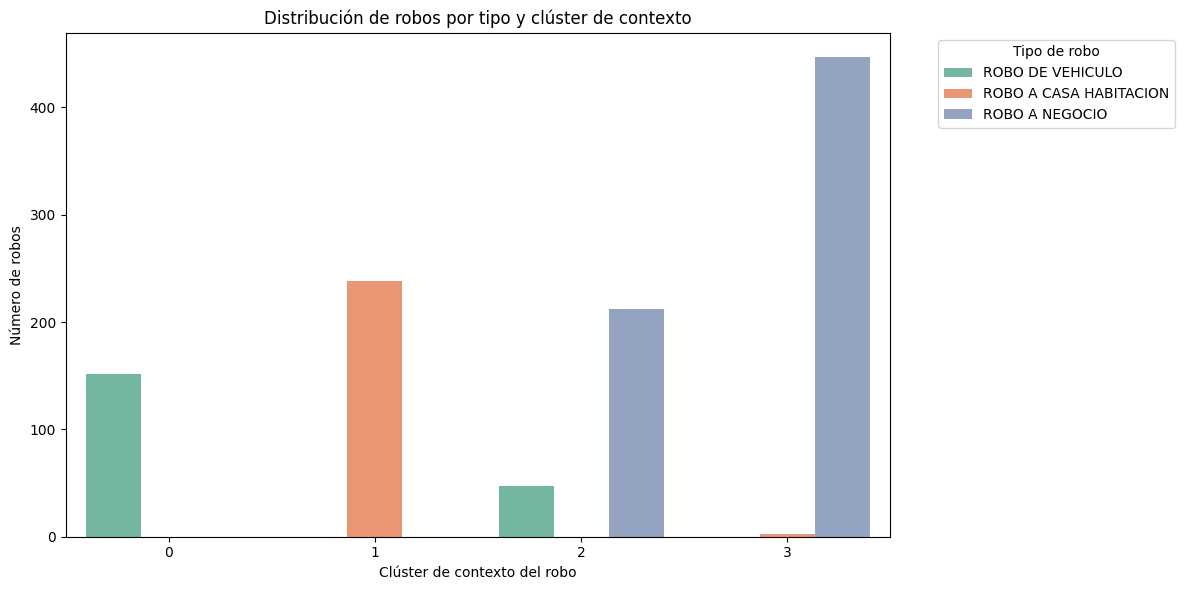

In [ ]:
# =====================================
# 10. Gráfica de barras: número de robos por clúster y tipo
# =====================================
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Cluster_Contexto", hue="TIPO", palette="Set2")
plt.title("Distribución de robos por tipo y clúster de contexto")
plt.xlabel("Clúster de contexto del robo")
plt.ylabel("Número de robos")
plt.legend(title="Tipo de robo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

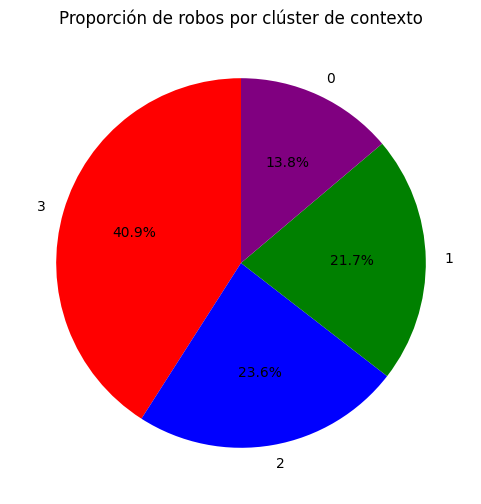

In [ ]:
# =====================================
# 11. Gráfica de pastel: proporción total de robos por clúster
# =====================================
plt.figure(figsize=(6,6))
df["Cluster_Contexto"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", colors=colores, startangle=90
)
plt.title("Proporción de robos por clúster de contexto")
plt.ylabel("")
plt.show()